# CSC 215 - Final Project

# Gender Classification with Deep Learning

## Khoi Hoang

In [117]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from IPython.display import Markdown, display
import matplotlib.pyplot as plt

%matplotlib inline

In [118]:
# Helper function
# Print markdown style
def printmd(string):
    display(Markdown(string))
    
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Manually load images

In [2]:
IMAGES_DIRECTORY = "C:/Users/hgdan/Downloads/lfw-deepfunneled/"

In [3]:
people = os.listdir(path=IMAGES_DIRECTORY)
print("There are {} people in the full lfw dataset.".format(len(people)))

There are 5749 people in the full lfw dataset.


In [4]:
image_array = []
for directory in os.listdir(IMAGES_DIRECTORY):
    image_dir = IMAGES_DIRECTORY + directory #go to sub directories
    for image in os.listdir(image_dir):
        image = plt.imread(os.path.join(image_dir, image))
        image_array.append(image)

In [5]:
image_array = np.array(image_array)
image_array.shape

(13233, 250, 250, 3)

#### Making the gender labels for the output

In [6]:
df_male = pd.read_csv("gender_labels/male_names.txt")
df_female = pd.read_csv("gender_labels/female_names.txt")

In [7]:
df_female.head()

,Pics
0,Claudia_Coslovich_0001.jpg
1,Allison_Searing_0001
2,Elizabeth_Hill_0001.jpg
3,Erika_Reyes_0001.jpg
4,Tatiana_Shchegoleva_0001.jpg


In [8]:
# Helper function to convert the df into list of names for males or females
def gender_to_list(df):
    temp = df.values
    temp = temp.reshape(temp.shape[0],)
    
    res = []
    for each in temp:
        each = each.rsplit('_', 1)[0]
        res.append(each)
    
    return res

In [9]:
male = gender_to_list(df_male)
female = gender_to_list(df_female)

In [10]:
female[0:5]

['Claudia_Coslovich',
 'Allison_Searing',
 'Elizabeth_Hill',
 'Erika_Reyes',
 'Tatiana_Shchegoleva']

In [11]:
gender_target = []
for each in os.listdir(IMAGES_DIRECTORY): #iterate through the subdir
    if each in male:
        for i in range(len(os.listdir(IMAGES_DIRECTORY + each))):
            gender_target.append('male')
    elif each in female:
        for i in range(len(os.listdir(IMAGES_DIRECTORY + each))):
            gender_target.append('female')
    else:
        print(each)

In [12]:
gender_target = np.array(gender_target)
gender_target.shape

(13233,)

In [13]:
gender_target

array(['male', 'male', 'male', ..., 'female', 'male', 'male'], dtype='<U6')

# Load data from sklearn

In [267]:
from sklearn.datasets import fetch_lfw_people

In [268]:
lfw_people = fetch_lfw_people(color = True)

In [269]:
lfw_people.images.shape

(13233, 62, 47, 3)

In [270]:
lfw_people.target_names.shape

(5749,)

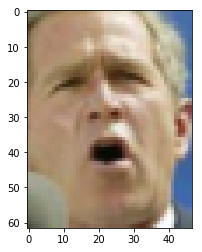

In [272]:
sample = 277
each = lfw_people.images[sample]

plt.figure()
plt.imshow(each/255)

In [273]:
lfw_people.target_names

array(['AJ Cook', 'AJ Lamas', 'Aaron Eckhart', ..., 'Zumrati Juma',
       'Zurab Tsereteli', 'Zydrunas Ilgauskas'], dtype='<U35')

#### Making gender labels for the output

In [274]:
df_male = pd.read_csv("gender_labels/male_names.txt")
df_female = pd.read_csv("gender_labels/female_names.txt")

In [275]:
df_male.shape

(10268, 1)

In [276]:
# Helper function to convert the df into list of names for males or females
def gender_to_list(df):
    temp = df.values
    temp = temp.reshape(temp.shape[0],)
    
    res = []
    for each in temp:
        each = each.replace('_', ' ').rsplit(' ', 1)[0]
        res.append(each)
    
    return res

In [277]:
male = gender_to_list(df_male)
female = gender_to_list(df_female)

In [278]:
female[0:5]

['Claudia Coslovich',
 'Allison Searing',
 'Elizabeth Hill',
 'Erika Reyes',
 'Tatiana Shchegoleva']

In [279]:
np.where(lfw_people.target_names=='Claudia Coslovich')

(array([1020], dtype=int64),)

In [280]:
lfw_people.target_names[0]

'AJ Cook'

In [281]:
np.where(lfw_people.target==1020)

(array([4095], dtype=int64),)

In [282]:
y = []
for each in lfw_people.target: #iterate through the ids
    if lfw_people.target_names[each] in male:
        y.append('male')
    elif lfw_people.target_names[each] in female:
        y.append('female')
    else:
        print(each)

In [283]:
y = np.array(y)

In [284]:
y.shape

(13233,)

In [285]:
lfw_people.target.shape

(13233,)

In [286]:
np.unique(y, return_counts=True)

(array(['female', 'male'], dtype='<U6'), array([ 2962, 10271], dtype=int64))

In [287]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

In [288]:
np.unique(y, return_counts=True)

(array([0, 1], dtype=int64), array([ 2962, 10271], dtype=int64))

In [289]:
dummies = pd.get_dummies(y)
dummies.head()

,0,1
0,0,1
1,0,1
2,0,1
3,0,1
4,1,0


In [290]:
y = dummies.values.astype(np.float32)
y

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

# Deep CNN model

In [291]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers, regularizers
from sklearn import metrics
from keras.optimizers import Adam

In [292]:
#x_train, x_test, y_train, y_test = train_test_split(image_array, gender_target, test_size=0.3, random_state=43)
x_train, x_test, y_train, y_test = train_test_split(lfw_people.images, y, test_size=0.2, random_state=43)

In [293]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(10586, 62, 47, 3)
(10586, 2)
(2647, 62, 47, 3)
(2647, 2)


In [294]:
# Normalize the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_test /= 255.0

In [295]:
y_train

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [296]:
# Label encode the gender
#le = preprocessing.LabelEncoder()
#y_train = le.fit_transform(y_train)
#y_test = le.fit_transform(y_test)

In [297]:
# One hot encode the gender
#y_train = keras.utils.to_categorical(y_train, 2)
#y_test = keras.utils.to_categorical(y_test, 2)

In [298]:
y_test[0:5]

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [299]:
checkpointer = ModelCheckpoint(filepath="save/cnn_1.hdf5", verbose=0, save_best_only=True) # save best model
#input_shape = (250, 250, 3)
input_shape = (62, 47, 3)
weight_decay = 1e-4

#Build network
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='valid',
                 activation='relu',
                 input_shape=input_shape)) 
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None))
model.add(Dropout(0.25)) 

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

model.fit(x_train,y_train, validation_data=(x_test,y_test), callbacks=[monitor,checkpointer],verbose=1,epochs=50, batch_size=64, shuffle=True)    # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
    
print('Training finished...Loading the best model')  
print()
model.load_weights('save/cnn_1.hdf5') # load weights from best model

Train on 10586 samples, validate on 2647 samples
Epoch 1/50
10586/10586 [==============================] - 6s 608us/step - loss: 1.0801 - acc: 0.7664 - val_loss: 0.4338 - val_acc: 0.7790
Epoch 2/50
10586/10586 [==============================] - 4s 361us/step - loss: 0.3733 - acc: 0.8392 - val_loss: 0.2907 - val_acc: 0.8904
Epoch 3/50
10586/10586 [==============================] - 4s 367us/step - loss: 0.3008 - acc: 0.8817 - val_loss: 0.2493 - val_acc: 0.9063
Epoch 4/50
10586/10586 [==============================] - 4s 376us/step - loss: 0.2633 - acc: 0.8972 - val_loss: 0.2359 - val_acc: 0.9135
Epoch 5/50
10586/10586 [==============================] - 4s 357us/step - loss: 0.2279 - acc: 0.9089 - val_loss: 0.2117 - val_acc: 0.9150
Epoch 6/50
10586/10586 [==============================] - 4s 355us/step - loss: 0.2183 - acc: 0.9143 - val_loss: 0.2037 - val_acc: 0.9226
Epoch 7/50
10586/10586 [==============================] - 4s 364us/step - loss: 0.2010 - acc: 0.9189 - val_loss: 0.1951 - v

In [300]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 60, 45, 32)        896       
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 58, 43, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 29, 21, 64)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 29, 21, 64)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 38976)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 128)               4989056   
_________________________________________________________________
dropout_29 (Dropout)         (None, 128)               0         
__________

-----------------**Convolutional Neural Network Report**---------------

F1 score: 0.9266822756176519
Confusion matrix: 
 [[ 475  113]
 [  79 1980]]
Plotting confusion matrix


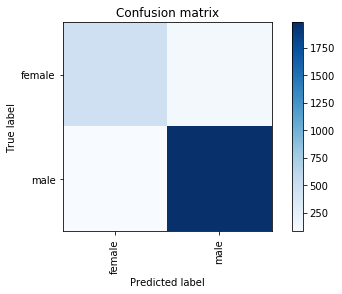

              precision    recall  f1-score   support

           0       0.86      0.81      0.83       588
           1       0.95      0.96      0.95      2059

   micro avg       0.93      0.93      0.93      2647
   macro avg       0.90      0.88      0.89      2647
weighted avg       0.93      0.93      0.93      2647



In [301]:
cnn_pred = model.predict(x_test)
cnn_pred = np.argmax(cnn_pred,axis=1)
y_true = np.argmax(y_test,axis=1)

cnn_f1 = metrics.f1_score(y_true, cnn_pred, average= "weighted")
cnn_cm = metrics.confusion_matrix(y_true, cnn_pred)
printmd("-----------------**Convolutional Neural Network Report**---------------")
print("F1 score: {}".format(cnn_f1))
print("Confusion matrix: \n", cnn_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cnn_cm, ["female", "male"])
plt.show()

print(metrics.classification_report(y_true, cnn_pred))